# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.330622,False,0.887729
1,-0.691849,False,-1.118670
2,0.193915,False,-0.966624
3,-0.535931,True,2.642023
4,2.334936,True,7.962068
...,...,...,...
995,0.339981,False,-0.948675
996,-0.919134,False,0.069790
997,-1.140944,False,-0.716580
998,0.352853,True,4.586724


<Axes: xlabel='v0'>

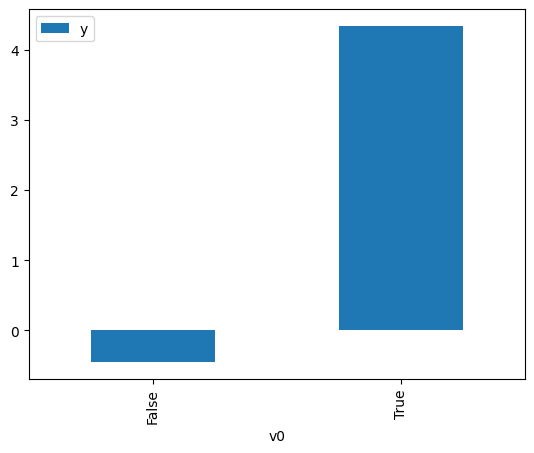

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

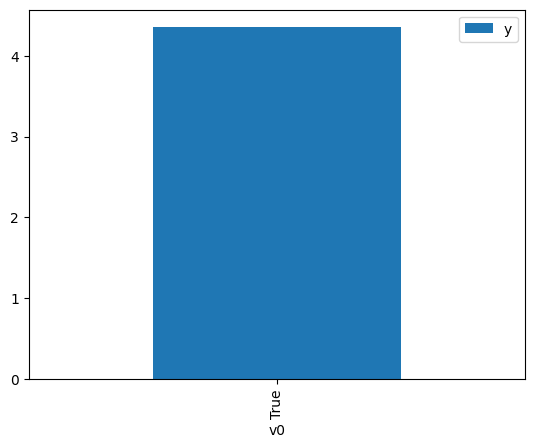

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.416171,False,-1.103170,0.587029,1.703494
1,1.020597,False,1.610446,0.256853,3.893284
2,0.289512,False,1.261112,0.415118,2.408955
3,-0.807504,False,-1.508775,0.676307,1.478619
4,-0.127578,False,0.523608,0.516908,1.934579
...,...,...,...,...,...
995,0.193915,False,-0.966624,0.438129,2.282434
996,-0.663361,False,-1.209901,0.644508,1.551571
997,0.507649,False,-0.926918,0.364117,2.746373
998,1.261393,False,0.781840,0.214268,4.667049


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.096630,True,1.579037,0.264752,3.777119
1,0.883869,True,6.774463,0.716633,1.395414
2,-1.335124,True,2.590650,0.221639,4.511850
3,-1.064736,True,4.180466,0.270908,3.691296
4,-0.712749,True,2.574438,0.344435,2.903306
...,...,...,...,...,...
995,-0.394069,True,4.852584,0.418255,2.390889
996,-2.109866,True,-0.132723,0.117258,8.528192
997,1.342959,True,7.022089,0.798937,1.251663
998,0.263952,True,3.750980,0.578761,1.727828


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              5840.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):                        0.00
Time:                        08:43:32   Log-Likelihood:                         -1436.2
No. Observations:                1000   AIC:                                      2876.
Df Residuals:                     998   BIC:                                      2886.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1002      0.028     39.374      0.000       1.045       1.155
x2             4.9739      0.050     99.704      0.000       4.876       5.072
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.380
Skew:                           0.047   Prob(JB):                        0.827
Kurtosis:                       2.984   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""